In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere include("../src/mat2tmpinst.jl")
@everywhere using TemporalInstanton

In [51]:
# compile everything with this run:
d = load_rts96_data(return_as_type=true);
# Thermal model parameters:
d.Tamb = 35. # C
d.T0 = 60. #46. # initial line steady-state temp

d.time_values = 0:600:3600 # one hour in ten-minute steps
d.int_length = 600. # seconds = ten min
Gp,Dp,Rp = d.G0,d.D0,d.R0
d.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
d.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
d.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(d);

n = length(d.k)
nr = length(d.Ridx)
T = convert(Int64,length(d.G0)/n)
o = process_instanton_results(results,n,nr,T,return_as_type=true);

sort(o.score)

104-element Array{Float64,1}:
    0.144203
    0.183047
    0.780308
    1.45965 
    1.48481 
    1.53048 
    3.07398 
    3.26632 
    3.30856 
    3.89312 
    4.04828 
    4.07651 
    4.25185 
    ⋮       
  123.529   
  218.664   
  240.558   
  240.558   
  268.214   
  287.057   
  630.437   
  660.602   
  887.298   
  945.097   
 1408.05    
 1408.05    

1.628496 seconds (18.18 k allocations: 2.226 MB)


In [3]:
using PyPlot
PyPlot.svg(true)

true

In [10]:
# Choose event index (1 is instanton):
eidx = 1

# System parameters:
n = length(d.k)
nr = length(d.Ridx)
T = round(Int64,length(find(d.R0))/nr)

6

In [18]:
p = return_conductor_params("waxwing")

# Thermal parameters:
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
# Tlim = 65.
# ηc = 0.955
# ηr = 2.207e-9
# qs = 14.4
# mCp = 383.
Tmid = (d.Tamb + p.Tlim)/2
therm_a = p.mCp\(-p.ηc - 4*p.ηr*(Tmid + 273)^3) # Fixed wrt power flow

-0.003270204441451697

In [19]:
# Line parameters:
idx = find(o.score.==sort(o.score)[eidx])[1]
nz_line_idx = intersect(find(d.line_lengths),find(d.res))

line = d.lines[nz_line_idx][idx]
from,to = line
r_ij = d.res[nz_line_idx][idx]
x_ij = d.reac[nz_line_idx][idx]
L_ij = d.line_lengths[nz_line_idx][idx]

43452.18

In [20]:
# Generate this many random vectors:
numVecs = 10
vecs = Array(Vector,0)

# First vector is instanton analysis output:
tempVec = Array(FloatingPoint,0)
for i in 1:T
    append!(tempVec,o.x[idx][i])
end
push!(vecs,tempVec)

# Second vector represents accurate forecast:
push!(vecs,zeros(length(vecs[1])))

# Third vector cancels all wind gen:
push!(vecs,-d.R0[find(d.R0)])

3-element Array{Array{T,1},1}:
 AbstractFloat[-0.0006466365892753845,-0.0023175276535732925,0.0007890044787757233,0.0007212890273535777,0.0006897492535955507,0.0004349839435695557,0.0001271400001600087,0.0006604623210080263,-4.217416879859215e-5,-0.00028457210447641046  …  -0.006947516407782128,-0.046878680010109974,-0.038337882319808614,-0.03734962047224144,-0.03759299252979531,-0.031605341324620895,-0.028312133162444297,0.044208167866266024,0.04545893214660168,0.044959766171103865]
 [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]                                                                                                                                                                                                                                                                                                                                                                                   
 [-0.0820657,-0.0450422,-0.484807,-0.819395,-0.152571

In [21]:
# Add a family of vectors with same norm as
# instanton vector:
for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(nr*T) - 0.5).*(i+1)/35
    # Normalize to match min-score objective:
    traj = sqrt(o.score[idx])*inter/norm(inter)
    push!(vecs,traj)
end

In [37]:
# Use power flow data and thermal model to compute
# temperature trajectories for each vector:
temp_trajectories = Array(Vector,0)
angle_dump = Array(Vector,0)
diffs_dump = Array(Vector,0)
for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    fixed_A = fixed_wind_A(T,d.Y,d.ref,d.k)
    fixed_P = expand_renewable_vector(fixed_wind,d.Ridx,n,T)
    fixed_b = fixed_wind_b(n,T,d.G0,d.R0+fixed_P,d.D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,n,T)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)
    
    T0 = d.T0
    temp_values = [d.T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*d.Sb/(3*L_ij) # W/m
        push!(power_flow,(d.Sb/1e6)*θij/x_ij)
        therm_b = p.mCp\( f_loss_si + p.ηc*d.Tamb - p.ηr*((Tmid + 273)^4 - (d.Tamb+273)^4) 
                                + 4*p.ηr*Tmid*(Tmid + 273)^3 + p.qs )
        temp_values = [temp_values;temp_eq(d.time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end
    push!(temp_trajectories,temp_values)
end

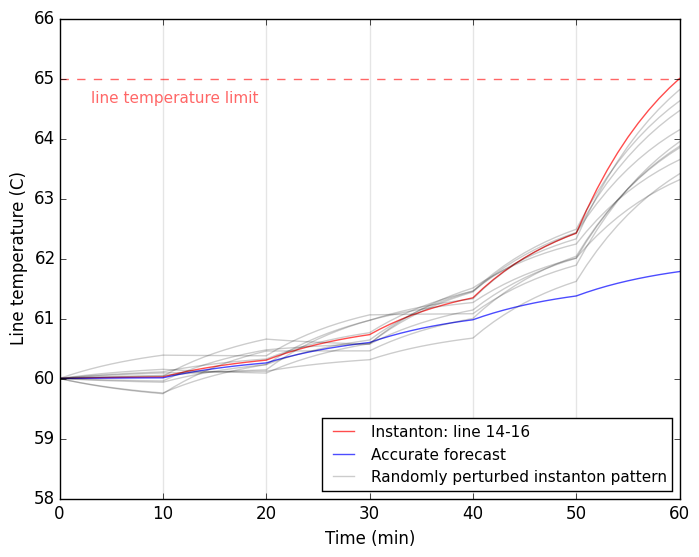

In [90]:
# Plot
# fig = figure(figsize=(6,5))
xvals = (0:length(temp_trajectories[1])-1)*T*d.int_length/(60*(length(temp_trajectories[1])-1))
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(xvals,temp_trajectories[i],alpha=0.7,"r")
        elseif i == 2
        plot(xvals,temp_trajectories[i],alpha=0.7,"b")
        elseif i == 3
        #plot(xvals,temp_trajectories[i],alpha=0.0,"g")
    else
        plot(xvals,temp_trajectories[i],alpha=0.2,"k")
    end
end
# title("Temperature vs Time for Line $(from)-$(to)",fontsize=12)
xlabel("Time (min)")
ylabel("Line temperature (C)")
legend(["Instanton: line $(from)-$(to)";
    "Accurate forecast";
    #     "No wind",
    "Randomly perturbed instanton pattern"],fontsize=11,loc=4)
axis([xvals[1],xvals[end],58,66])
for i in 1:T
    xval = i*d.int_length/60
    plot([xval,xval],[40,1.1*p.Tlim],"k",alpha=0.1)
end
plot([xvals[1],xvals[end]],[p.Tlim,p.Tlim],"r--",alpha=0.6)
text(3,64.6,"line temperature limit",color="red",fontsize=11,alpha=0.6)#color="#FFB2B2")

savefig("../paper2/images/temptrajectory.pdf")